Grain 1/20 placed at (3300,3184) axes=(353,223) rough=0.06
Grain 2/20 placed at (1366,3154) axes=(379,178) rough=0.07
Grain 3/20 placed at (2264,1107) axes=(581,327) rough=0.09
Grain 4/20 placed at (491,133) axes=(371,107) rough=0.06
Grain 5/20 placed at (543,3308) axes=(268,541) rough=0.05
Grain 6/20 placed at (3516,1802) axes=(713,736) rough=0.05
Grain 7/20 placed at (2519,3895) axes=(472,738) rough=0.07
Grain 8/20 placed at (280,2089) axes=(178,246) rough=0.08
Grain 9/20 placed at (937,2464) axes=(415,374) rough=0.07
Grain 10/20 placed at (508,4340) axes=(332,127) rough=0.07
Grain 11/20 placed at (4314,3227) axes=(390,613) rough=0.10
Grain 12/20 placed at (1327,1557) axes=(711,407) rough=0.08
Grain 13/20 placed at (2361,1971) axes=(246,235) rough=0.09
Grain 14/20 placed at (4542,1306) axes=(132,653) rough=0.08
Grain 15/20 placed at (4187,762) axes=(182,448) rough=0.09
Grain 16/20 placed at (1642,3386) axes=(572,64) rough=0.09
Grain 17/20 placed at (2229,3143) axes=(59,450) rough=0.1

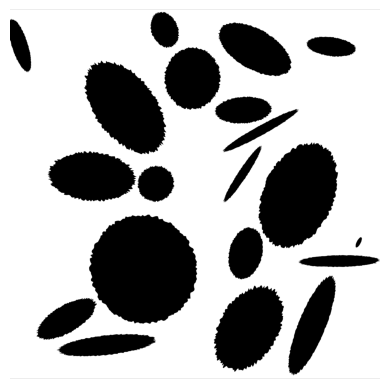

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import polygon
from scipy.ndimage import binary_dilation

def generate_grain(shape, center, axes, angle=0, roughness=0.15, n_points=200):
    """Generate irregular ellipse mask."""
    t = np.linspace(0, 2*np.pi, n_points)
    x = axes[1] * np.cos(t)
    y = axes[0] * np.sin(t)
    r_noise = 1 + roughness * (np.random.rand(n_points) - 0.5)
    x, y = x * r_noise, y * r_noise
    xr = x*np.cos(angle) - y*np.sin(angle)
    yr = x*np.sin(angle) + y*np.cos(angle)
    rr, cc = polygon(yr + center[0], xr + center[1], shape)
    mask = np.zeros(shape, dtype=bool)
    mask[rr, cc] = True
    return mask

def generate_porous_media_adaptive(Nx=5000, Ny=5000, n_grains=100, buffer=7,
                                    axis_range_y=(20,200), axis_range_x=(20,200),
                                    roughness_range=(0.05,0.25),
                                    angle_range=(0,2*np.pi),
                                    max_attempts=200):
    
    domain = np.ones((Nx, Ny), dtype=np.int32)
    domain[-1, :] = 0
    domain[0, :] = 0
    available = np.ones((Nx, Ny), dtype=bool)
    placed = 0

    sizes_y = np.arange(axis_range_y[1], axis_range_y[0]-1, -1)
    sizes_x = np.arange(axis_range_x[1], axis_range_x[0]-1, -1)

    active_sizes_y = sizes_y.copy()
    active_sizes_x = sizes_x.copy()

    while placed < n_grains and len(active_sizes_x) > 1 and len(active_sizes_y) > 1:
        ay = np.random.choice(active_sizes_y)
        ax = np.random.choice(active_sizes_x)
        cy, cx = np.random.randint(ay+5, Nx-ay-5), np.random.randint(ax+5, Ny-ax-5)

        angle = np.random.uniform(*angle_range)
        rough = np.random.uniform(*roughness_range)

        grain = generate_grain((Nx, Ny), (cy, cx), (ay, ax), angle, rough)

        if np.any(~available[grain]):
            max_attempts -= 1
            if max_attempts <= 0:
                if len(active_sizes_y) > 1:
                    active_sizes_y = active_sizes_y[1:]
                if len(active_sizes_x) > 1:
                    active_sizes_x = active_sizes_x[1:]
                max_attempts = 200
                print(f"Dropping largest sizes → new range Y:{active_sizes_y[0]}-{active_sizes_y[-1]} "
                      f"X:{active_sizes_x[0]}-{active_sizes_x[-1]}")
            continue

        domain[grain] = 0
        placed += 1
        print(f"Grain {placed}/{n_grains} placed at ({cy},{cx}) "
              f"axes=({ay},{ax}) rough={rough:.2f}")

        if buffer > 0:
            taken = binary_dilation(grain, iterations=buffer)
        else:
            taken = grain
        available[taken] = False

    print(f"\nSummary: placed {placed}/{n_grains} grains "
          f"(final active sizes Y:{active_sizes_y[-1]} X:{active_sizes_x[-1]})")
    return domain

Nx = 5000
Ny = 5000
domain = generate_porous_media_adaptive(Nx=Nx, Ny=Ny, n_grains=20, axis_range_x=(50, 750), axis_range_y=(5, 750), roughness_range=(0.05, 0.1), buffer=10)

plt.imshow(domain, cmap="gray")
plt.axis("off")
plt.show()

domain_linear = np.reshape(domain, (Nx*Ny, 1), order='F')
np.savetxt("pore_raw.txt", domain_linear, fmt="%i")
